## 載入套件

In [306]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import pandas as pd

## 封閉解價格

In [307]:
def asian_option_closed_form_V1(S0, K, T, r, sigma, option_type):
    """
    :param S: 初始資產價格
    :param K: 選擇權行使價格
    :param T: 選擇權到期日
    :param r: 無風險利率
    :param sigma: 波動率
    :param option_type: 選擇權類型，可以是'call'或'put'
    :return: 亞式選擇權的價格估計
    """
    sigma_G = sigma * (T / np.sqrt(3))
    b = (r - 0.5 * sigma_G**2)
    sqrt_T = np.sqrt(T)
    d1 = (np.log(S0 / K) + (b + 0.5 * sigma_G**2) * T) / (sigma_G * sqrt_T)
    d2 = d1 - sigma_G * sqrt_T

    if option_type == 'call':
        option_price = (S0 * np.exp((b - r) * T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2))
    else:
        option_price = (K * np.exp(-r * T) * norm.cdf(-d2) - S0 * np.exp((b - r) * T) * norm.cdf(-d1))

    return option_price, norm.cdf(d1), norm.cdf(d2)

# 設定模擬參數
S0 = 100  # 初始資產價格
K = 100  # 選擇權行使價格
T = 1  # 選擇權到期日
r = 0.05  # 無風險利率
sigma = 0.2  # 波動率

# 封閉解公式計算亞式選擇權價格
option_price = asian_option_closed_form_V1(S0, K, T, r, sigma, option_type='call')
print(f'亞式選擇權價格（Call）：{option_price}')

option_price = asian_option_closed_form_V1(S0, K, T, r, sigma, option_type='put')
print(f'亞式選擇權價格（Put）：{option_price}')

亞式選擇權價格（Call）：(6.893931378517671, 0.6674972289489853, 0.6245840579554415)
亞式選擇權價格（Put）：(2.6813232030856398, 0.6674972289489853, 0.6245840579554415)


## 價值變化模擬

In [308]:
def asian_option_closed_form(S, K, T, r, sigma, n, dt, option_type):

    Tt = T - dt*n
    sigma_G = sigma * (Tt / np.sqrt(3))
    b = (r - 0.5 * sigma_G**2)
    sqrt_Tt = np.sqrt(Tt)
    d1 = (np.log(S / K) + (b + 0.5 * sigma_G**2) * (Tt)) / (sigma_G * sqrt_Tt)
    d2 = d1 - sigma_G * sqrt_Tt

    if option_type == 'call':
        option_price = (S * np.exp((b - r) * Tt) * norm.cdf(d1) - K * np.exp(-r * Tt) * norm.cdf(d2))

    if option_type == 'put':
        option_price = (K * np.exp(-r * Tt) * norm.cdf(-d2) - S * np.exp((b - r) * Tt) * norm.cdf(-d1))

    return option_price

def asian_option_average_price_path_simulation(S0, K, T, r, sigma, n, m, option_type):
    dt = T / n
    nudt = (r - 0.5 * sigma**2) * dt
    sigsdt = sigma * np.sqrt(dt)
    price_paths = []
    np.random.seed(123)

    for i in range(m):
        S = S0
        price_path = []
        for n1 in range(n):
            option_value = asian_option_closed_form(S, K, T, r, sigma, n1, dt, option_type)
            epsilon = np.random.normal(0, 1)
            S *= np.exp(nudt + sigsdt * epsilon)    
            price_path.append(option_value)
        # print(price_path[0])  # 確認期初價格是否有誤
        price_paths.append(price_path)
        
    return price_paths



## Asian Option Paths Simulation

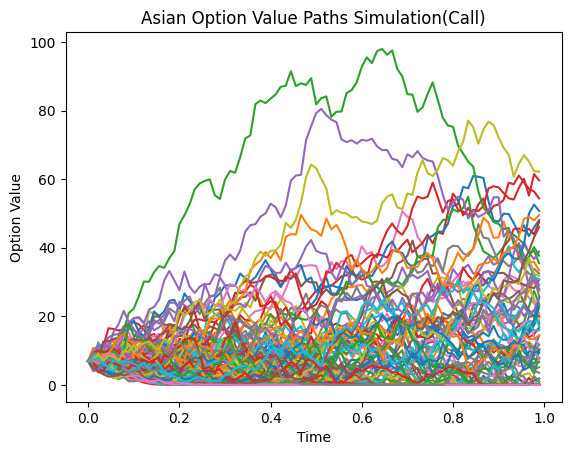

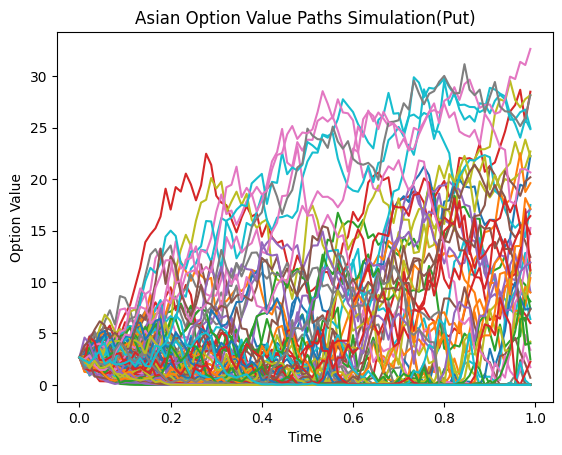

In [352]:
# 設定模擬參數
S0 = 100  # 初始資產價格
K = 100  # 選擇權行使價格
T = 1  # 選擇權到期日
r = 0.05  # 無風險利率
sigma = 0.2  # 波動率
n = 90  # 每期分割的次數
m = 100 # 模擬的次數
option_type = 'call'
price_paths = asian_option_average_price_path_simulation(S0, K, T, r, sigma, n, m, option_type)


# 繪製價值路徑
for i, price_path in enumerate(price_paths):
    plt.plot(np.arange(0, T, T / n), price_path, label=f'Simulation {i + 1}')


plt.xlabel('Time')
plt.ylabel('Option Value')
plt.title('Asian Option Value Paths Simulation(Call)')
# plt.legend()
plt.show()
# ============================================================================================ #
option_type = 'put'
price_paths = asian_option_average_price_path_simulation(S0, K, T, r, sigma, n, m, option_type)


# 繪製價值路徑
for i, price_path in enumerate(price_paths):
    plt.plot(np.arange(0, T, T / n), price_path, label=f'Simulation {i + 1}')

plt.xlabel('Time')
plt.ylabel('Option Value')
plt.title('Asian Option Value Paths Simulation(Put)')
# plt.legend()
plt.show()

## 蒙地卡羅方法求解價格

In [350]:
# 設定模擬參數 (expect: c=6.89,p=2.68)
S0 = 100  # 初始資產價格
K = 100  # 選擇權行使價格
T = 1  # 選擇權到期日
r = 0.05  # 無風險利率
sigma = 0.2  # 波動率
n = 90  # 每期分割的次數
m = 100 # 模擬的次數

def average_price_path_simulation(S0, K, T, r, sigma, n, m):
    dt = T / n
    nudt = (r - 0.5 * sigma**2) * dt
    sigsdt = sigma * np.sqrt(dt)
    price_paths = []
    np.random.seed(123)

    for i in range(m):
        S = S0
        geometric_average_S = S0

        for n1 in range(n):
            epsilon = np.random.normal(0, 1)
            S *= np.exp(nudt + sigsdt * epsilon)  
            # 改用log 
            geometric_average_S *= S
            
        geometric_average_S = geometric_average_S ** (1 / (n+1)) # 考慮初始價格，總共有 n+1 個需要取平均
        price_paths.append(geometric_average_S)
    return price_paths

def mc_option_value(optiontype):
    price_paths = average_price_path_simulation(S0, K, T, r, sigma, n, m)
    a = pd.DataFrame(price_paths)
    if optiontype == 'call':
        a = a - K
    else:
        a = K - a 
    a = a[0].apply(lambda x: max(0, x))
    average_option_value = a.mean()
    option_value = average_option_value*np.exp(-r*T)
    return option_value

print(f'亞式選擇權價格（Call）：{mc_option_value(optiontype="call")}')
print(f'亞式選擇權價格（Put）：{mc_option_value(optiontype="put")}')

print((mc_option_value(optiontype="call")-6.89)/6.89)
print((mc_option_value(optiontype="put")-2.86)/2.86)

亞式選擇權價格（Call）：6.555058190834672
亞式選擇權價格（Put）：2.986881459250223
-0.04861274443618684
0.044364146590987134


## Delta v.s. Time to Maturity(ATM)

/var/folders/nm/qsv7jp0x4gxdpcssmk1d_bq00000gn/T/ipykernel_98280/735848748.py:19: RuntimeWarning: invalid value encountered in scalar divide
  d1 = (np.log(S0 / K) + (r + 1/6 * (sigma**2)) * 0.5*(T - t)) / (sigma * np.sqrt((T - t)/3))
/var/folders/nm/qsv7jp0x4gxdpcssmk1d_bq00000gn/T/ipykernel_98280/735848748.py:20: RuntimeWarning: invalid value encountered in scalar divide
  d2 = (np.log(S0 / K) + (r - 1/6 * (sigma**2)) * 0.5*(T - t)) / (sigma * np.sqrt((T - t)/3))
/var/folders/nm/qsv7jp0x4gxdpcssmk1d_bq00000gn/T/ipykernel_98280/735848748.py:21: RuntimeWarning: divide by zero encountered in scalar divide
  bs_delta = np.exp(-(r + 1/6*sigma**2) * (T - t)) * norm.cdf(d1) + 1/(sigma * np.sqrt(2*np.pi*(T-t)/3)) * (np.exp(-(r*(T-t)/2+(T-t)*sigma**2 /12 + d1**2 /2)) - K/S0 * np.exp(-(r*(T-t) + d2**2 /2)) )


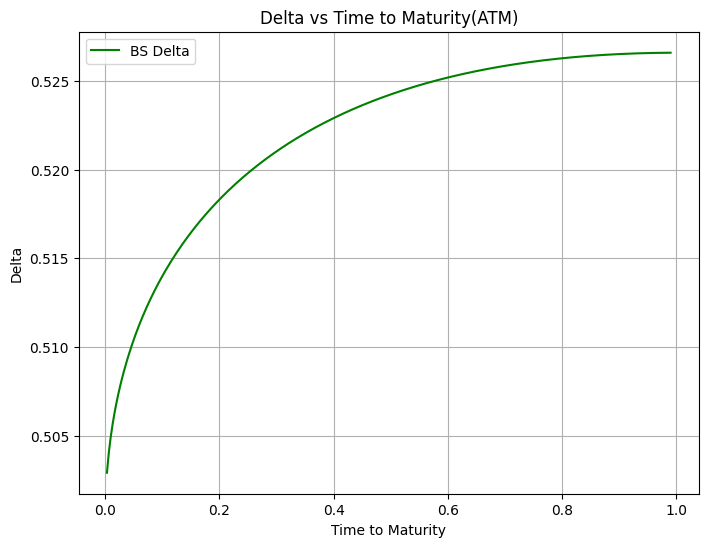

In [28]:
# Delta 公式解

# 參數
S0 = 100  
K = 100  
r = 0.02  
sigma = 0.2  
T = 1.0  

# 时间步长和模拟次数
n_steps = 300

bs_delta_values = []
time_to_expiry = []


for t in np.linspace(0.01, T, n_steps):
    time_to_expiry.append(T - t)
    d1 = (np.log(S0 / K) + (r + 1/6 * (sigma**2)) * 0.5*(T - t)) / (sigma * np.sqrt((T - t)/3))
    d2 = (np.log(S0 / K) + (r - 1/6 * (sigma**2)) * 0.5*(T - t)) / (sigma * np.sqrt((T - t)/3))
    bs_delta = np.exp(-(r + 1/6*sigma**2) * (T - t)) * norm.cdf(d1) + 1/(sigma * np.sqrt(2*np.pi*(T-t)/3)) * (np.exp(-(r*(T-t)/2+(T-t)*sigma**2 /12 + d1**2 /2)) - K/S0 * np.exp(-(r*(T-t) + d2**2 /2)) )
    bs_delta *= np.exp(-r * (T - t))
    bs_delta_values.append(bs_delta)


plt.figure(figsize=(8, 6))
plt.plot(time_to_expiry, bs_delta_values, color='green', label='BS Delta')
plt.title('Delta vs Time to Maturity(ATM)')
plt.xlabel('Time to Maturity')
plt.ylabel('Delta')
plt.legend()
plt.grid(True)
plt.show()

##  Delta for geometric Asian call option at different stock price S

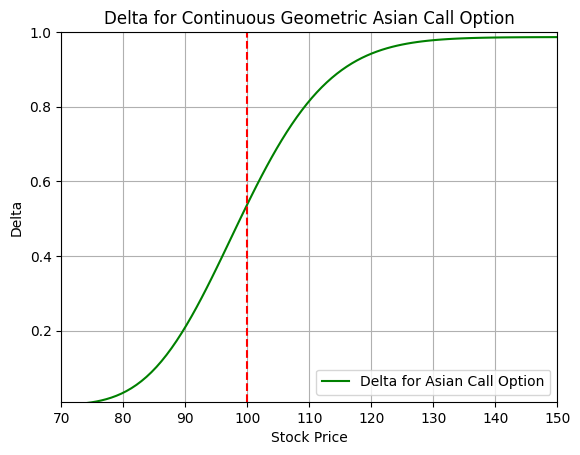

In [30]:
import math
def asian_option_delta_continuous(S, K, T, r, sigma):
    sqrt_T = np.sqrt(T/3)
    sqrt_pi = np.sqrt(2*math.pi)
    d1 = (np.log(S / K) + (r + (sigma**2)/6) * (T/2)) / (sigma * sqrt_T)
    d2 = (np.log(S / K) + (r - (sigma**2)/2) * (T/2)) / (sigma * sqrt_T)
    delta = np.exp(-(r + (sigma**2)/6)* (T/2)) * norm.cdf(d1) 
    + (1/sigma*sqrt_T*sqrt_pi)*(np.exp(-(r*0.5*T + T*(sigma**2)/12 + (d1**2)*0.5)) - (K/S)*np.exp(-(r*T + (d2**2)*0.5)))
    return delta

# Example usage
T = 1.0    # Time to expiration (in years)
r = 0.02   # Risk-free interest rate
sigma = 0.2  # Volatility

# Range of stock prices
S_values = np.linspace(70, 150, 100)

# Calculate Delta for each stock price
delta_values = [asian_option_delta_continuous(S, 100.0, T, r, sigma) for S in S_values]

# Plot the Delta
plt.plot(S_values, delta_values, color='green', label='Delta for Asian Call Option')
plt.xlabel('Stock Price')
plt.ylabel('Delta')
plt.xlim(70,150)
plt.ylim(0.01,1.0)
plt.title('Delta for Continuous Geometric Asian Call Option')
plt.legend()
plt.grid(True)
plt.axvline(x=100, color='red', linestyle='--', label='Strike Price = 100')
plt.show()


## Gamma for geometric Asian call option at different stock price S

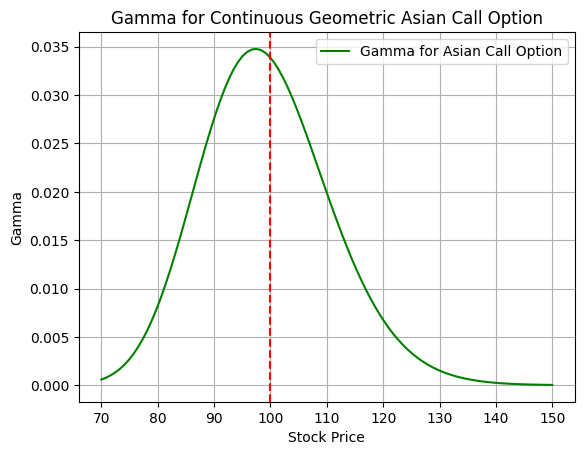

In [31]:
def asian_option_gamma_continuous(S, K, T, r, sigma):
    sqrt_T = np.sqrt(T/3)
    sqrt_pi = np.sqrt(2*math.pi)
    d1 = (np.log(S / K) + (r + (sigma**2)/6) * (T/2)) / (sigma * sqrt_T)
    d2 = (np.log(S / K) + (r - (sigma**2)/2) * (T/2)) / (sigma * sqrt_T)
    index_1 = (3/(S*sigma*T))*(np.log(S/K) + 2*(r + (sigma**2)/6)*T)
    index_2 = index_1 - (2*sigma*np.sqrt(T))/(S*np.sqrt(3))
    gamma = np.exp(-(r + (sigma**2)/6)* (T/2)) * norm.pdf(d1)*(1/(S*sigma*sqrt_T))
    + (1/(sigma*sqrt_pi*sqrt_T))*(-np.exp(-(r*T*0.5 + ((T*sigma**2)/12) + 0.5*d1**2))*index_1 + (K/S**2)*np.exp(-(r*T + (0.5*d2**2))) + (K/S)*np.exp(-(r*T + (0.5*d2**2)))*0.5*index_2 )

    return gamma

# Example usage
T = 1.0    # Time to expiration (in years)
r = 0.02   # Risk-free interest rate
sigma = 0.2  # Volatility

# Range of stock prices
S_values = np.linspace(70, 150, 100)

# Calculate Gamma for each stock price
gamma_values = [asian_option_gamma_continuous(S, 100.0, T, r, sigma) for S in S_values]

# Plot the Gamma
plt.plot(S_values, gamma_values, color = 'green', label='Gamma for Asian Call Option')
plt.xlabel('Stock Price')
plt.ylabel('Gamma')
plt.title('Gamma for Continuous Geometric Asian Call Option')
plt.legend()
plt.grid(True)
plt.axvline(x=100, color='red', linestyle='--', label='Strike Price = 100')
plt.show()


## Vega for geometric Asian call option at different stock price S (SKIP)


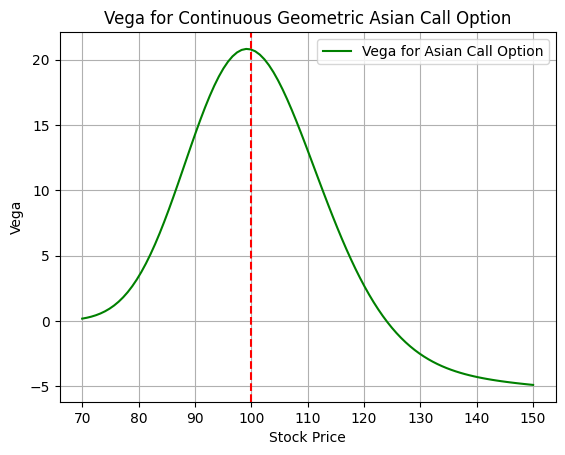

In [32]:
def asian_option_vega_continuous(S, K, T, r, sigma):
    sqrt_T = np.sqrt(T/3)
    d1 = (np.log(S / K) + (r + (sigma**2)/6) * (T/2)) / (sigma * sqrt_T)
    vega = (S*np.exp(-(r + (sigma**2)/6)*0.5*T))*(sqrt_T*norm.pdf(d1) - ((sigma*T)/6)*norm.cdf(d1))
    return vega

# Example usage
T = 1.0    # Time to expiration (in years)
r = 0.02   # Risk-free interest rate
sigma = 0.2


# Range of stock prices
S_values = np.linspace(70, 150, 100)

# Different values of theta
# theta_values = [0.2, 0.15, 0.12]

# # Plot the Vega for each value of theta
# for theta in theta_values:
#     vega_values = [asian_option_vega_continuous(S, K, T, r, theta) for S in S_values]
#     plt.plot(S_values, vega_values, label=f'Theta = {theta}')
vega_values = [asian_option_vega_continuous(S, 100.0, T, r, sigma) for S in S_values]

plt.plot(S_values, vega_values, color = 'green', label='Vega for Asian Call Option')
plt.xlabel('Stock Price')
plt.ylabel('Vega')
plt.title('Vega for Continuous Geometric Asian Call Option')
plt.legend()
plt.grid(True)
plt.axvline(x=100, color='red', linestyle='--', label='Strike Price = 100')
plt.show()
## Delta v.s Time to Maturity (Monte Carlo)
import numpy as np
import matplotlib.pyplot as plt

## Delta v.s Time to Maturity (Monte Carlo)

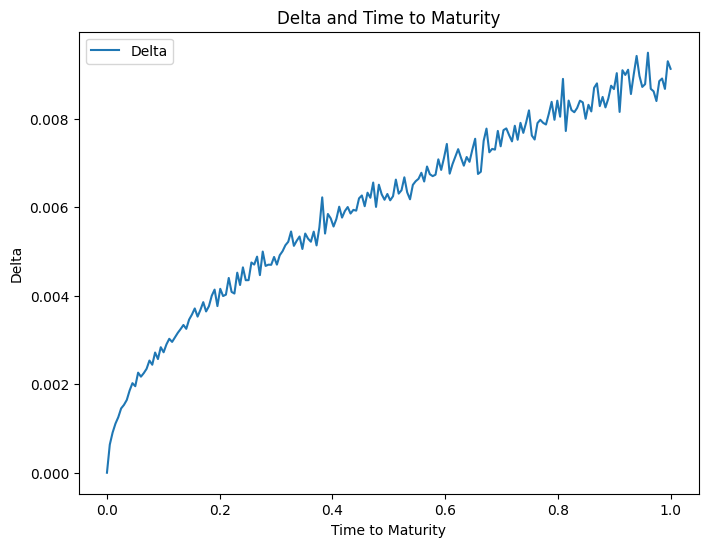

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# 參數
S0 = 1  
K = 1   
r = 0.00  
sigma = 1
T = np.linspace(0.00, 1, 200)  
n_simulations = 2000

# 非公式解
def asian_option_delta(S0, K, r, sigma, T, n_simulations):
    delta_values = []

    for t in T:
        dt = t / n_simulations
        average_prices = []
        S = S0
        # np.random.seed(123)
        for _ in range(n_simulations):
            n_values = np.arange(1, n_simulations + 1)
            data = np.exp(r * dt * n_values) * S * np.exp(sigma * np.sqrt(dt) * np.random.normal(0, 1))
            # print(np.random.randn(n_simulations))
            average_price = np.exp(np.mean(np.log(data)))
            # average_price = data
            average_prices.append(average_price)

        option_payoffs = np.maximum(np.array(average_prices) - K, 0)
        delta = np.exp(-r * t) * np.mean(option_payoffs) / (S0 * np.exp(-r * t))
        delta = np.mean(option_payoffs) / (S0)
        delta_values.append(delta)

    return delta_values


delta_values = asian_option_delta(S0, K, r, sigma, T, n_simulations)

# 
plt.figure(figsize=(8, 6))
plt.plot(T, delta_values, label='Delta')
plt.title('Delta and Time to Maturity')
plt.xlabel('Time to Maturity')
plt.ylabel('Delta')
# plt.grid(True)
plt.legend()
plt.show()
